<H1><CENTER> Machine Learning Lab - Exercise Sheet 9 <br /></CENTER></H1>
<H2><CENTER> Author: Sebastian Pineda Arango  <br />
ID: 246098<br />
Universität Hildesheim - Data Analytics Master </CENTER></H2>

<img src="https://www.uni-hildesheim.de/typo3conf/ext/unihildesheim/Resources/Public/Images/logo-uni.svgz" width="100">

In this notebook, we want to develop spam classifier using suppoert vector machines. For that, we use two libraries: LIBSVM and Scikit-learn.

The library LIBSVM was installed from this repository: https://www.lfd.uci.edu/~gohlke/pythonlibs/#libsvm

Where we use the following command for the installation:

Command used: "pip install libsvm-3.23-cp36-cp36m-win_amd64.whl"

Some help to change the parameters of the libsvm model was takne from:
https://lmb.informatik.uni-freiburg.de/lectures/old_lmb/svm_seminar/java/libsvmdemo.html

#### Datasets

Two datasets are used to create the spam classifier. The datasets are donwloaded from the following sources: 
* Dataset 1: 
https://archive.ics.uci.edu/ml/datasets/Spambase

* Dataset 2:
https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection


#### Support vector machines

The support vecotr machines is, in general, a linear classifeir which aims to find a separating hyperplane so that the margin between one class and another is maximized. The idea of margin is depicted in the following image (own authorship):

<img src="images/svm.jpg" width="300">

That means that the support vector machines optimization problem could be expressed in the following way [2]:

$\min_{\textbf{w},b}    \frac{1}2||\textbf{w}||$

$s.t. \, y_i(\textbf{w}^T\textbf{x}_i+b)\geq 1$

## Exercise 1: Spam filter using SVM

A spam filter is created using spam dataset 1 and the library "libsvm". This library accept format in the following way (libsvm format):

$<label> \space <index1>:<value> \space <index2>:<value2> \space...$

There is a function in scikit-learn that enables the creation of dataset in this format: $load\_svm\_light\_file ()$. However, we implement the function to convert a sparse matriz into this libsvm format. The following steps are performed:

* Importing libraries
* Importing data
* Exploring data
* Splitting data in train-test
* Cross validation
* Choosing the best final model

In [1]:
#Importing libraries
from svmutil import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [75]:
#Importing data
data1 = pd.read_csv("data\spambase\spambase.data", header=None)
data1.rename(columns={57:"y"}, inplace = 0.6)

data1.shape

(4601, 58)

In [76]:
#Exploring the data
data3.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,y
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [77]:
data1.groupby('y')['y'].count()

y
0    2788
1    1813
Name: y, dtype: int64

In [78]:
print("Mean of y value:", np.mean(data3['y']))

Mean of y value: 0.39404477287546186


After exploring the data, we have the following insights:

* There are 4601 samples and 57 features. 
* The class label (y), which corresponds to 1 when it is spam and to 0 when it is not. There is 39.4% of data from class not-spam.
* If we look the documentation, the features are divided in the following way:
    - 48 features corresponds to the frequency of the word (in percentage). Where they take the frequency of the word, and divide it by the total number of words of the e-mail.
    - 6 features are percentage of given chars on the email.
    - 1 feature for the average length of uninterrupted sequence of capital letters.
    - 1 feature for the average length of uninterrupted sequence of capital letters.
    - 1 feature for the sum of length of uninterrupted sequences of capital letters.
    
Now we split data in training and test, where we assing 80% of the data to test.

In [6]:
#Splitting train and test

def split_train_test(data, train_pct, features, target):
    
    '''This functions divides "data"  in train and test set.
    The percentage give to the train data is determined by "train_pct".
    The "features" argument determine a list of features to consider.
    The "target" arugment indicates the the variable to predict.'''
    
    #getting the total number of training samples
    data_size = data.shape[0]
    train_size = int(train_pct*data_size)

    #shuffling indexes to separate train and test randoming
    idx = np.arange(0,data_size)
    np.random.shuffle(idx)

    #creating test indexes
    train_idx = idx[:train_size]

    #creating test indexes
    test_idx = idx[train_size:]

    #selecting train data (features)
    X_train = data[features].iloc[train_idx,]

    #selecting train data (target)
    y_train = data[target].iloc[train_idx,]

    #selecting test data (features)
    X_test = data[features].iloc[test_idx,]

    #selecting test data (target)
    y_test = data[target].iloc[test_idx,]


    return X_train, y_train, X_test, y_test

In [105]:
X = np.array(data3.iloc[:,:-1])
y = np.array(data3.iloc[:,-1])
col_names = data3.columns[:-1]

X_train, y_train, X_test, y_test = split_train_test(data1, 0.8, col_names, 'y')

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Train size:",X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 3680
Test size: 921


Now we store the train data in libsvm format, so that we can use it in future implementations.

In [96]:
import sklearn.datasets as sk_dt

sk_dt.dump_svmlight_file(X_train, y_train, 'train_data')
sk_dt.dump_svmlight_file(X_test, y_test, 'test_data')

We define a function that converts sparse matrices (with a lot of zero values) into _libsvm_ format. Having this, we can input the matrices to the _libsvm_ train function.

In [97]:
def convert_to_format(X):

    '''This function converts X in a libsvm format.'''
    
    n_train = X.shape[0]

    #list to store the new format
    X_dok_format = []
    
    #iterating over all the data
    for i in range(n_train):
        
        #getting indexes different to zero
        key=np.where(X[i,]!=0)
        
        #getting values of indexes different to zero
        val=X[i,key]
        
        #creating a dictionary with the last values
        x= dict(zip(list(key[0]),list(val[0])))
        
        #appending the dictionary (libsvm format) to list
        X_dok_format.append(x)
        
    return X_dok_format

The main objective now is to pick the best hyperparameter C. To do that,we apply k-fold cross validation.

In [98]:
#number of samples of training set
n_train = X_train.shape[0]

#number of folds
n_folds = 5

#initializing folds
folds = []
samples_fold = int(n_train/n_folds)

#creating the k-fold subsets
for i in range(n_folds):
    
    folds.append((X_train[(i*samples_fold):((i+1)*samples_fold),:],
                   y_train[(i*samples_fold):((i+1)*samples_fold)]))

folds_list = list(range(n_folds+1))

#initialize list to store the man of each hyperparameter setting
mean_test_folds = []
mean_train_folds = []

#list of hyperparameters
c_list = [0.01,0.1,1,2,5,10,20,50,100]

for c in c_list:

    print("Trying c=",c)
    test_acc_folds = []
    train_acc_folds = []
    
    for f in range(n_folds):

            #list of folds
            folds_list = list(range(n_folds))
            folds_list.pop(f)

            #selecting test dataset
            X_test_fold = folds[f][0]
            y_test_fold = folds[f][1]

            #merging the folds to create the training dataset
            X_train_fold = folds[folds_list[1]][0]   
            y_train_fold = folds[folds_list[1]][1]
            
            for j in folds_list[1:]:
                X_train_fold = np.vstack((X_train_fold, folds[j][0]))
                y_train_fold = np.hstack((y_train_fold, folds[j][1]))
            
            #converting data to libsvm format
            X_train_fold = convert_to_format(X_train_fold)
            X_test_fold = convert_to_format(X_test_fold)
            y_train_fold = list(y_train_fold)
            y_test_fold = list(y_test_fold)
            
            #training the model
            param = '-c '+ str(c)
            
            m = svm_train( y_train_fold, X_train_fold, param)
            
            acc_train=svm_predict(y_train_fold, X_train_fold, m)
            acc_test = svm_predict(y_test_fold, X_test_fold, m)
            
            #finding accuracy over the fold
            train_acc_folds.append(acc_train[1][0])
            test_acc_folds.append(acc_test[1][0])
            
    #findning the mean across all the folds
    mean_train_folds.append(np.mean(train_acc_folds))
    mean_test_folds.append(np.mean(test_acc_folds))



Trying c= 0.01
Accuracy = 60.0204% (1767/2944) (classification)
Accuracy = 62.0924% (457/736) (classification)
Accuracy = 60.0204% (1767/2944) (classification)
Accuracy = 60.1902% (443/736) (classification)
Accuracy = 59.1372% (1741/2944) (classification)
Accuracy = 61.9565% (456/736) (classification)
Accuracy = 60.428% (1779/2944) (classification)
Accuracy = 56.7935% (418/736) (classification)
Accuracy = 59.7826% (1760/2944) (classification)
Accuracy = 59.375% (437/736) (classification)
Trying c= 0.1
Accuracy = 87.7717% (2584/2944) (classification)
Accuracy = 72.1467% (531/736) (classification)
Accuracy = 87.7717% (2584/2944) (classification)
Accuracy = 73.7772% (543/736) (classification)
Accuracy = 87.2962% (2570/2944) (classification)
Accuracy = 78.125% (575/736) (classification)
Accuracy = 79.0421% (2327/2944) (classification)
Accuracy = 63.8587% (470/736) (classification)
Accuracy = 86.9565% (2560/2944) (classification)
Accuracy = 75.1359% (553/736) (classification)
Trying c= 1
Ac

Text(0.5,1,'Accucary vs. Hyperparameter C')

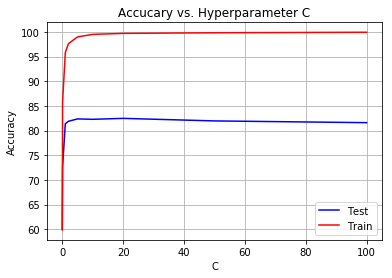

In [115]:
plt.plot(c_list, mean_test_folds, 'b')
plt.plot(c_list, mean_train_folds, 'r')
plt.grid()
plt.legend(['Test', 'Train' ])
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title('Accucary vs. Hyperparameter C')

In [116]:
df =pd.DataFrame({'C':c_list, 'Average mean train':mean_train_folds, 'Average mean test':mean_test_folds})

df[[ 'C', 'Average mean test', 'Average mean train']]

,C,Average mean test,Average mean train
0,0.01,60.081522,59.877717
1,0.10,72.608696,85.767663
2,1.00,81.385870,95.781250
3,2.00,81.875000,97.588315
4,5.00,82.364130,98.967391
5,10.00,82.282609,99.483696
6,20.00,82.472826,99.687500
7,50.00,81.956522,99.816576
8,100.00,81.603261,99.918478


According to the table, the best model is the one with C=20, so we retrain the model with the whole train data set and compute accuracy on the test set. The accuracy on the test set is 85.342% which is close to the mean test accuracy of the k-fold cross validaiton (82.47%).

In [106]:
X_train = convert_to_format(X_train)
y_train = list(y_train)

X_test = convert_to_format(X_test)
y_test = list(y_test)

m = svm_train(y_train, X_train, '-c 20')
p=svm_predict(y_test, X_test, m)

Accuracy = 85.342% (786/921) (classification)


## Part B: Pre-processing and learning SVM

The seconde dataset is donwloaded This dataset is the mixture of different datasets of SMS message. They are labeled as SPAM or HAM. However, we get row text, therefore, the columns should be processed to get features that can be used on a learning algorithm. 

To perform this task, the following steps are done:

* Importing the data
* Importing stop_words
* Converting to lower case
* Taking out special characters and numbers
* Counting word
* Term frequency matrix
* Grid seach
* Choosing and training of final model
* Evaluating final model

In [2]:
#Importing data
data2 = pd.read_csv("data\smsspamcollection\SMSSpamCollection", sep="\t", names=['Label', 'Text'])

In [4]:
data2.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


After importing, the stop words are imported from the library "stop_words". This library contains a large list of stop words for english that can be used to preprocess the dataset.

In [3]:
#Importing stop words
from stop_words import  get_stop_words
import re

en_stop = get_stop_words('en')
print("Some stop words:", en_stop[1:10])

Some stop words: ['about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']


Now, the text is processed so that all letters are converted to lower case, and numbers an special characters are eliminated. We also filter all stops words from training set.

In [4]:
data2.Text = data2.Text.apply(lambda x: x.lower()) ###All lower casetext
data2.Text = data2.Text.apply(lambda x: re.sub(r'[^\w\s]','',x)) #only alpha-numeric and space
data2.Text = data2.Text.apply(lambda x: re.sub(r'[0-9]','',x)) #filtering numbers

#filtering stop words from all samples
for stop_word in en_stop:
    data2.Text = data2.Text.apply(lambda x: re.sub(r' '+stop_word+' ',' ', x) )

data2.Text.head()

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry  wkly comp win fa cup final tkts st...
3                  u dun say early hor u c already say
4          nah dont think goes usf lives around though
Name: Text, dtype: object

In [8]:
#splitting train and test
X_train, y_train, X_test, y_test = split_train_test(data2, 0.8, ['Text'], 'Label')

print("Shape of train:", X_train.shape)
print("Shape of test:", X_test.shape)

Shape of train: (4457, 1)
Shape of test: (1115, 1)


In order to convert text to numbers, we perfomr a tf-idf transformation. TF-IDF transfrmation finds for each term $t$ in a document $d$ the normalized frequency ($tf$) and the inverse frequency ($idf$):

$tf(t,d) = \frac{f(t,d)}{max\{f(t,d):t \space \epsilon \space d\}}$

$idf(t,D) = log\frac{|D|}{|\{d \space \epsilon \space D \space : t \space \epsilon \space d \}|}$

Where:

* $|D|$: is the number of samples (numer of documents)
* $|\{d \space \epsilon \space D \space : t \space \epsilon \space d \}|$: is the number of documents where the term $t$ appears

Finally, the TFIDF is calculated as [1]:

$tfidf(t,d,D) = tf(t,d)\times idf(t,D)$

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#getting the frequency of terms
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.iloc[:,0])
X_train_counts.shape

(4457, 7597)

In [11]:
#getting the tf-idf transformation
tfidf_transf = TfidfTransformer().fit(X_train_counts)
X_train_tfidf = tfidf_transf.transform(X_train_counts)
X_train_tfidf

<4457x7597 sparse matrix of type '<class 'numpy.float64'>'
	with 39296 stored elements in Compressed Sparse Row format>

In [12]:
#transforming test data
X_test_counts = count_vect.transform(X_test.iloc[:,0])
X_test_tfidf = tfidf_transf.transform(X_test_counts)
X_test = X_test_tfidf.toarray()

#transforming labels (originally the are strings)
y_train = np.array([1 if i=="ham" else 0 for i in y_train])
y_test = np.array([1 if i=="ham" else 0 for i in y_test])

In [13]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm

#creating the hyperaparameter list
kernel_list = ['linear', 'rbf']
c_list=[0.01, 0.1, 1, 10, 20, 30, 100]

#creating initial classifier
clf = svm.SVC( )

#creating hyperparameter dicionary for grid searh
parameters={'C':c_list, 'kernel':kernel_list}

#creating scorer for grid search
f1_scorer = make_scorer(f1_score)

#performing grid search
svm_grid = GridSearchCV(clf, parameters, cv=5, scoring=f1_scorer)

#fitting data
svm_grid.fit(X_train_tfidf, y_train)

#choosing the best estimator
best_svm= svm_grid.best_estimator_

print("Best classifier:")
best_svm

Best classifier:


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
#printing the hyperparameter set list
svm_grid.cv_results_['params']

[{'C': 0.01, 'kernel': 'linear'},
 {'C': 0.01, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 0.1, 'kernel': 'rbf'},
 {'C': 1, 'kernel': 'linear'},
 {'C': 1, 'kernel': 'rbf'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 10, 'kernel': 'rbf'},
 {'C': 20, 'kernel': 'linear'},
 {'C': 20, 'kernel': 'rbf'},
 {'C': 30, 'kernel': 'linear'},
 {'C': 30, 'kernel': 'rbf'},
 {'C': 100, 'kernel': 'linear'},
 {'C': 100, 'kernel': 'rbf'}]

In [15]:
#creating table to plot
x_axis = [(i['C'], i['kernel']) for i in svm_grid.cv_results_['params']]
y_axis = svm_grid.cv_results_['mean_test_score']
pd.DataFrame({'C':x_axis, 'Mean F1':y_axis })

,C,Mean F1
0,"(0.01, linear)",0.927704
1,"(0.01, rbf)",0.927704
2,"(0.1, linear)",0.953030
3,"(0.1, rbf)",0.927704
4,"(1, linear)",0.986173
5,"(1, rbf)",0.927704
6,"(10, linear)",0.986158
7,"(10, rbf)",0.927704
8,"(20, linear)",0.986031
9,"(20, rbf)",0.927704


In [16]:
#prediction on new (test) data
pred_test = best_svm.predict(X_test_tfidf)
f1_score(y_test, pred_test)

0.9882111737570477

The f1-score on test (0.9882) is very similar to the one obtained during cross validation for the best hyeraparameter set (f1-score = 0.9861). It implies good generalization. We can also see from the next boxplot, that over the folds, the deviation from the mean score is very low.

Text(0,0.5,'F1-score')

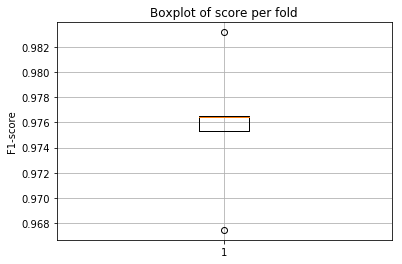

In [20]:
from sklearn.model_selection import cross_val_score

metrics_svm = cross_val_score(best_svm, X_train_tfidf, y_train, cv=5)
plt.boxplot(metrics_svm)
plt.grid()
plt.title("Boxplot of score per fold")
plt.ylabel("F1-score")

# Exercise 2: Compare SVM based spam flter wth another model (Gradient Boosting Tree)

Now we want to compare the previous model, with another model. For that, we choose gradient boosting trees implementation of scikit-learn. Thanks to the ensemble model involved in the GBT, they tend also to give a very good generalization. We find the best hyperparameter set for this model using cross-validation. The consiered hyperparameters are: max depth and number of estimators.

In [21]:
#importing and creating classifiert
from sklearn import ensemble
gbc = ensemble.GradientBoostingClassifier()

In [35]:
#hyperparameter slist
max_depth_list = [2,10,100]
n_estimators_list=[5, 50, 100, 200]

#creating hyperaparamter list for grid search
parameters={'max_depth': max_depth_list, 'n_estimators': n_estimators_list}

#creating scorer for f1-score
f1_scorer = make_scorer(f1_score)

#grid search over the hyperparameter set
gbc_grid = GridSearchCV(gbc, parameters, cv=5, scoring=f1_scorer, verbose=1)
gbc_grid.fit(X_train_tfidf, y_train)

#choosing the best estimator
best_gbc= gbc_grid.best_estimator_
best_gbc

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  6.3min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [36]:
x_axis = [(i['max_depth'], i['n_estimators']) for i in rf_grid.cv_results_['params']]
y_axis = rf_grid.cv_results_['mean_test_score']
pd.DataFrame({'C':x_axis, 'Mean F1':y_axis })

,C,Mean F1
0,"(2, 5)",0.932078
1,"(2, 50)",0.967502
2,"(2, 100)",0.973739
3,"(2, 200)",0.979350
4,"(10, 5)",0.967793
5,"(10, 50)",0.974688
6,"(10, 100)",0.975831
7,"(10, 200)",0.976863
8,"(100, 5)",0.974640
9,"(100, 50)",0.973663


In [37]:
#prediction on new (test) data
pred_test = best_rf.predict(X_test_tfidf)
f1_score(y_test, pred_test)

0.98168870803662267

Text(0,0.5,'F1-score')

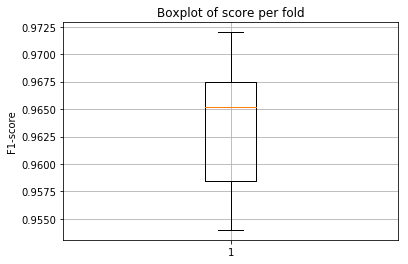

In [34]:
metrics_gbc = cross_val_score(best_rf, X_train_tfidf, y_train, cv=5)

metrics_gbc = cross_val_score(best_rf, X_train_tfidf, y_train, cv=5)
plt.boxplot(metrics_rf)
plt.grid()
plt.title("Boxplot of score per fold")
plt.ylabel("F1-score")

With GBC the results are very similar to the ons obtained with SVM (only slighylt lower f1-score in test set). For svm the score on training set was: 0.9882 and for gradient boosting, we obtained 0.9816. However the main difference is on the standar deviation from the results in SVM and GB. We see that the standard deviation of the k-fold results is much lower than for GB. This shows that SVM is able to reach similar resutls for the different sets, therefore it has a better generalization. In fact, this is a well know property of the SVM [2].

## References:

[1] Term frequency - inverse document frequency (tf-idf): https://es.m.wikipedia.org/wiki/Tf-idf

[2] C. Bishop. _Machine Learning and Pattern Recogtion_". Springer